# Comparing 3D genome organization

## Introduction

### High thoughput chromatin HiC

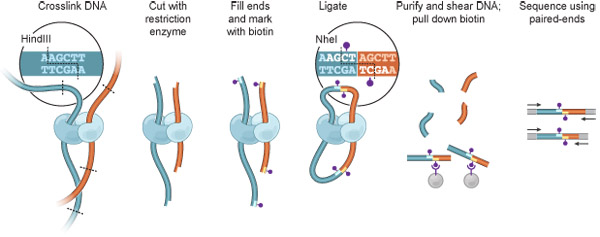

<i> Lieberman-Aiden E, van Berkum NL, Williams L, et al. Comprehensive mapping of long-range interactions reveals folding principles of the human genome. Science. 2009;326(5950):289-293. doi:10.1126/science.1181369 </i>

Describe the High throuput Chromatin (HiC) comformation capture: See report

----------------------------------------------------

The HiC genome data has now many libraries to deal with that kind of data, the bioinformatic field has made huge advancement recently. <br>
However, in Python, most of these libraries use special data format (cooler, Hic... ) and are mostly efficient for pre-processing the data. For our case, the data is already processed, and is in an npz format, so we can skip these methods as it is too complicated to convert the data. <br>

## Importing libraries

In [32]:
import numpy as np
import scipy
from scipy.sparse import coo_matrix
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from gtda.mapper.filter import Projection
from gtda.mapper.cover import OneDimensionalCover, CubicalCover

from gtda.mapper.pipeline import make_mapper_pipeline
from gtda.mapper.visualization import plot_static_mapper_graph



from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import umap

import warnings
warnings.filterwarnings("ignore")


## Looking at the data

Taking 2 random examples from the data: 1CDX1.12 and 1CDX1.192.

In [33]:
data = np.load('GTML/1CDX1.12/cmatrix_500k.npz')

shape=list(data['shape'])
dat=list(data['data'])
row=list(data['row'])
col=list(data['col'])
mat12=coo_matrix((dat,(row,col)), shape=shape).toarray()

mat12

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
data = np.load('GTML/1CDX1.192/cmatrix_500k.npz')

shape=list(data['shape'])
dat=list(data['data'])
row=list(data['row'])
col=list(data['col'])
mat192=coo_matrix((dat,(row,col)), shape=shape).toarray()

mat192

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## plotting the matrice

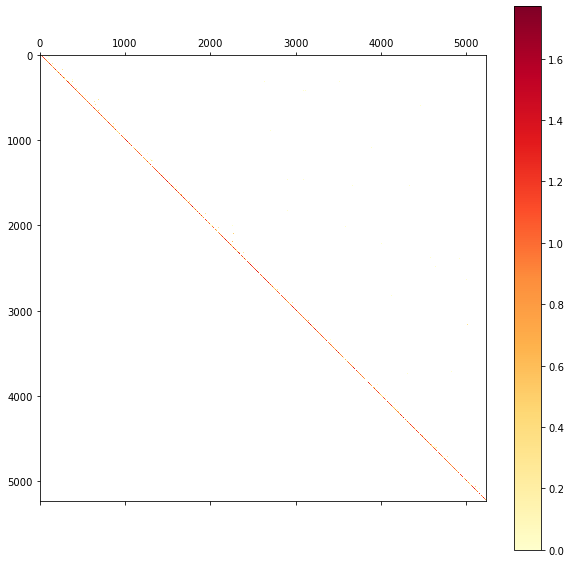

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
im = ax.matshow( np.log10(mat12), cmap='YlOrRd')
fig.colorbar(im)

As the data has been processed throughly, we cannot deduct many things from it, however, we can see that apart from the diagonal, the majority matrix values are 0s.

## Looking at the Pearson correlation plot

Using the corrcoef function in numpy

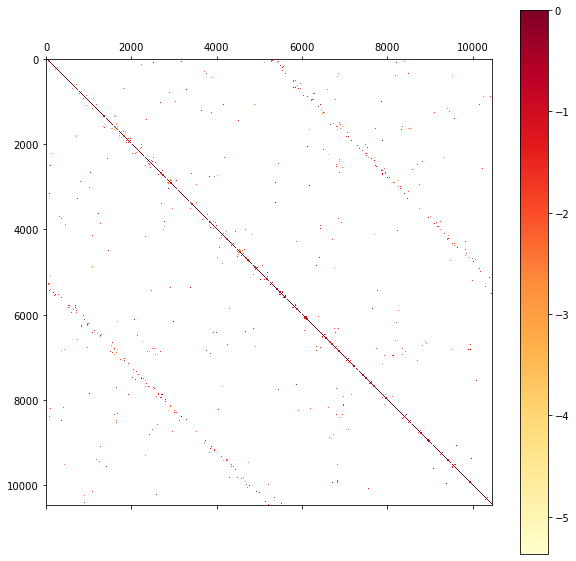

In [36]:
pearson = np.corrcoef(mat192,mat12)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
im = ax.matshow( np.log10(pearson), cmap='YlOrRd')
fig.colorbar(im)

The correlation between the matrices is obvious, however, notice that the Numpy corrcoef function generates a correlation matrix in the (10468,10468) against (5234,5234) in the data.

### Importing the chromsize data

In [37]:
chromsize=pd.read_csv('chromosomes.txt',sep='\t',index_col=0,names=['name','starts','ends','wheigths'])
chromsize.head()

,starts,ends,wheigths
name,,,
chr1,0,394,NaN
chr2,395,758,NaN
chr3,759,1078,NaN
chr4,1079,1390,NaN
chr5,1391,1696,NaN


## Pearson Correlations Coefficient

We define a function to calculate the Pearson correlation without extra dimension.

In [38]:
# def correlation_map(x, y):

#     mu_x = x.mean(1)
#     mu_y = y.mean(1)
#     n = x.shape[1]

#     s_x = x.std(1, ddof=n - 1)
#     s_y = y.std(1, ddof=n - 1)
#     cov = np.dot(x,y.T) - n * np.dot(mu_x[:, np.newaxis],mu_y[np.newaxis, :])
    
#     return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

In [39]:
# cor=generate_correlation_map(mat12,mat192)

This function calculates the Pearson correlation coeffecient that we use for computing the SCC

A variation of the Pearson correlation coefficient is written as follows:
$$ r_{xy}= \frac{1}{n-1} \Sigma_{i=1}^n(\frac{x_i-\bar{x}}{s_x})(\frac{y_i-\bar{y}}{s_y})$$

Where $s_x$ is the standrad deviation. <br>

In [40]:
def correlation_coefficient(m1, m2):
    numerator = np.mean((m1 - m1.mean()) * (m2 - m2.mean()))
    denominator = m1.std() * m2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result


## Strantum-adjusted correlation coefficient (SCC)

<b>Strantum-adjusted correlation coefficient(SCC):</b> is a way to test the reproducibility of the HiC data...

$$ SCC=\frac{\Sigma_{i=1}^s r_i(m-i) \sqrt{var(v_i^x)var(v_i^y)}}{\Sigma_{i=1}^s (m-i) \sqrt{var(v_i^x)var(v_i^y)}} $$

With $v_i$ the i-th stratum, (m-i) the length of $v_i$, $r_i$ the Pearson correlation coefficient of $v_i^x$ and $v_i^y$. <br>
And $var(v_i)=\frac{\Sigma_{j=1}^{m-i}(v_{i,j}-\bar{v_{i}})^2}{m-i} $

<i> Yang T, Zhang F, Yardımcı GG, et al. HiCRep: assessing the reproducibility of Hi-C data using a stratum-adjusted correlation coefficient. Genome Res. 2017;27(11):1939-1949. doi:10.1101/gr.220640.117 </i>

We code the function:

In [41]:
def scc (mat1, mat2):
    var_1=var_2=up=down=0 #initializing some variables

    for i in range (0,len(chromsize)):
        #co=np.corrcoef(mat1[chromsize['starts'][i]:chromsize['ends'][i]],mat2[chromsize['starts'][i]:chromsize['ends'][i]])
        #co=generate_correlation_map(mat1[chromsize['starts'][i]:chromsize['ends'][i]],mat2[chromsize['starts'][i]:chromsize['ends'][i]])
        
        co=correlation_coefficient(mat12[chromsize['starts'][i]:chromsize['ends'][i]],mat192[chromsize['starts'][i]:chromsize['ends'][i]])
        #Calculating the pearson correlation coefficient
        #This is the r_i parameter in the equation.

        len_s=chromsize['starts'][i]-chromsize['ends'][i]
        #the length of every strata: this is the (m-i) parameter in the equation
        mu_1=mat1[chromsize['starts'][i]:chromsize['ends'][i]].mean()
        mu_2=mat1[chromsize['starts'][i]:chromsize['ends'][i]].mean()
        #The average of every strata, this is the bar{v_i} in the equation

        for j in (chromsize['starts'][i],chromsize['ends'][i]):
            var_1=var_1+(mat1[j]-mu_1)
            var_2=var_2+(mat2[j]-mu_2)
            #The var parameters on the equation
            
                    
        
        var=np.sqrt(np.square((var_1/len_s)*(var_2/len_s)))  #the square root product of the var
        up=up+(len_s*co*var) #This is the numerator of the equation
        down=down+(len_s*var) # This is the denominator
    
    
    return sum(up)/sum(down) #Returning the SCC 
        



In [42]:
scc12_192=scc(mat12,mat192)
scc12_192

0.0949751200486353

#### Fetching a considerable amount of data (keeping it low because of computing power)

In [80]:
mats=[]
for i in range (1,5):
    for j in range (1,100): #limited computing power
        filepath='GTML/1CDX'+str(i)+'.'+str(j)+'/cmatrix_500k.npz'
        try:
            data = np.load(filepath)
            shape=list(data['shape'])
            dat=list(data['data'])
            row=list(data['row'])
            col=list(data['col'])
            mat=coo_matrix((dat,(row,col)), shape=shape).toarray()
            mats.append(mat)
        except FileNotFoundError:
            pass


#### Calculating the pairwise SCC correlatin matrix

In [81]:
corr=np.zeros((len(mats),len(mats)))
for i in range (1,len(mats)):
    for j in range (1,len(mats)):
        corr[i][j]=scc(mats[i],mats[j])
            

Calculating distances, see chapter  4.2 in the <a href= https://github.com/YousOuad/Hi-C-TDA-analysis/blob/main/3d_genome_HiC_data_analysis.pdf >article </a>

In [82]:
#Calculating the distances
d=np.zeros([len(corr),len(corr)])
for i in range (0,len(corr)):
    for j in range (0,len(corr)):
        d[i,j]=np.sqrt(corr[i,i]+corr[j,j]-2*corr[i,j])
        
d[np.isnan(d)]=0

## Building and visualizing the Mapper

### Using Giotto-AI

In [83]:
filter_func = umap.UMAP(n_neighbors=5) 

# Define cover
cover = CubicalCover(kind='balanced', n_intervals=10, overlap_frac=0.2)

# Choose clustering algorithm 
clusterer = DBSCAN(eps=10)

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=True,
    n_jobs=-1,
)

In [85]:
# Plot Mapper graph
fig = plot_static_mapper_graph(pipe, d)
fig.show(config={'scrollZoom': True})

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   3.5s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   3.5s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.3s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


In [86]:
d.shape

(251, 251)

The data is huge and needs a very  long time to process, here we took 251 cells data (matrices), fr

In [22]:
pca=PCA()
mat12_reduc=pca.fit_transform(mat12)
mat12_reduc.shape

(5234, 5234)

In [49]:
um=umap.UMAP()
mat12_reduc=um.fit_transform(mat12)
mat12_reduc.shape


(5234, 2)

<AxesSubplot:>

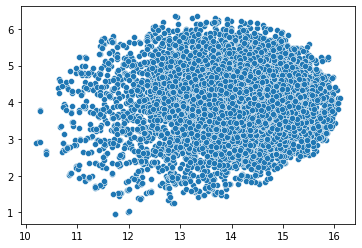

In [76]:
sns.scatterplot(mat12_reduc[:,0],mat12_reduc[:,1])